# Notebook Setup
Installs necessary requirements and configures proper notebook behavior  
Note: The notebook assumes you are using the base conda environment

In [1]:
%load_ext autoreload
%autoreload 2
    
print("Notebook setup has completed")

Notebook setup has completed


# Load Data
Load the data from the csv file into a pandas dataframe

In [4]:
MOVIES_JSON_PARAMS = {
    'file': 'Movies_and_TV_5.json',
    'features': "reviewText",
    'labels': "overall",
}

In [61]:
from preprocessing import get_dataframe_file
df = get_dataframe_file(MOVIES_JSON_PARAMS, points=5000)

In [64]:
df.head()

,reviewText,overall
1891852,Don't waste your hard-earned money. This movi...,1
2666389,Best deal ever,5
1230363,Pretty good scary movie.,3
1323191,Funny Movie. I would recommend. Worth renting,3
226525,great movie a little off the wall as history g...,5


# Preprocess Data
Split into training, testing, and validation sets, and vectorize the data

In [63]:
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import get_subsets

word_vectorizer = CountVectorizer(
    min_df=0.001, 
    max_df=0.7
 )
X = df["reviewText"].to_numpy()
X = word_vectorizer.fit_transform(X)
y = df['overall'].to_numpy()

X_train, X_val, X_test, y_train, y_val, y_test = get_subsets(X,y, train_split=0.8, val_split=0.1, test_split=0.1)


ValueError: np.nan is an invalid document, expected byte or unicode string.

# Visualize Data Distribution

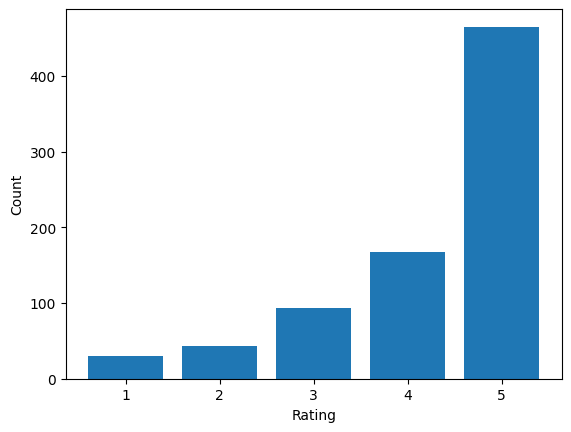

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.bar(np.unique(y_train, return_counts=True)[0], np.unique(y_train, return_counts=True)[1])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# Training the Model

In [31]:
print("Data and shapes:")
print("X_train:", type(X_train), "of shape", X_train.shape)
print("Y_train:", type(y_train), "of shape", y_train.shape)

Data and shapes:
X_train: <class 'scipy.sparse._csr.csr_matrix'> of shape (800, 58112)
Y_train: <class 'numpy.ndarray'> of shape (800,)


  0%|          | 0/500 [00:00<?, ?it/s]c:\Users\matth\Documents\Homework\COMP5630\ML-Project\mlp.py:12: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-X))
c:\Users\matth\Documents\Homework\COMP5630\ML-Project\mlp.py:15: RuntimeWarning: overflow encountered in exp
  a = 1.0 / (1.0 + np.exp(-X))
100%|██████████| 500/500 [00:57<00:00,  8.64it/s]


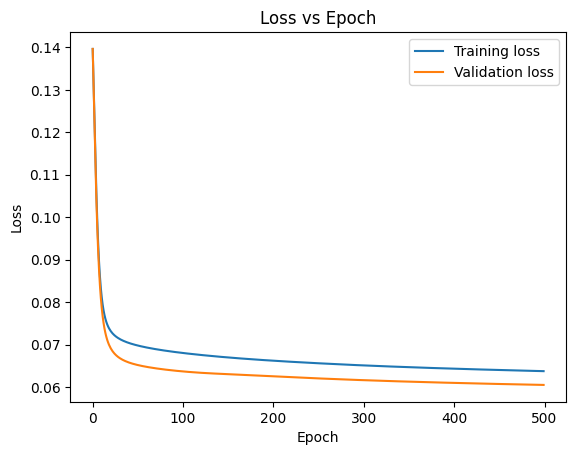

In [56]:
from mlp import MultiLayerPerceptron
clf = MultiLayerPerceptron(
    epochs=500,
    lr=0.1,
    hidden_layers=[50, 20],
    activation="sigmoid",
)
clf.fit(X_train, y_train, X_val, y_val, batch_size=200)
clf.plot_loss()

In [57]:
print(f"Training accuracy: {clf.score(X_train, y_train)}")
print(f"Testing accuracy: {clf.score(X_test, y_test)}")

Training accuracy: 0.525
Testing accuracy: 0.53


In [60]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
cm = classification_report(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         9
           3       0.20      0.11      0.14         9
           4       0.00      0.00      0.00        23
           5       0.58      0.93      0.72        56

    accuracy                           0.53       100
   macro avg       0.16      0.21      0.17       100
weighted avg       0.35      0.53      0.41       100



c:\Users\matth\Documents\Homework\COMP5630\ML-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matth\Documents\Homework\COMP5630\ML-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\matth\Documents\Homework\COMP5630\ML-Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [156]:
from multiprocessing import Pool, cpu_count
from multip import train_mlp
import numpy as np

PROCCESSES = cpu_count() - 1
classifiers = []
with Pool(PROCCESSES) as p:
    classifiers = p.map(train_mlp, [(X_train, y_train, X_test, y_test)] * PROCCESSES)
accuracies = [clf.score(X_test, y_test) for clf in classifiers]
print(accuracies, ":", np.mean(accuracies))
print(np.argmax(accuracies), "is the best classifier")
best_clf = classifiers[np.argmax(accuracies)]

[0.9096, 0.9101, 0.9123, 0.9111, 0.9086, 0.911, 0.9091, 0.9147, 0.9124, 0.9123, 0.9119, 0.9102, 0.9092, 0.913, 0.9111] : 0.9111066666666666
7 is the best classifier


In [157]:

p = best_clf.predict_proba(X_test)
p = p @ np.array([-1,1]).reshape(2,1)
print(f"Most positive example is {np.argmax(p)}")
print(f"Most negative example is {np.argmin(p)}")
print(f"Most neutral example is {np.argmin(np.abs(p))}")

p = (p*0.5 + 0.5)
incorrect_amount = p - y_test.reshape(-1,1)
print(f'Most incorrect example is {np.argmax(np.abs(incorrect_amount))}')


Most positive example is 6197
Most negative example is 8165
Most neutral example is 5622
Most incorrect example is 2694


In [165]:
example = 6197
print(f"Predicted: {best_clf.predict(X_test[example])[0]} {p[example]}\nActual: {y_test[example]}")
print(word_vectorizer.inverse_transform(X_test[example])[0])


Predicted: 1 [1.]
Actual: 1
['one' 'has' 'just' 'you' 'be' 'are' 'right' 'as' 'what' 'with' 'br'
 'violence' 'which' 'from' 'go' 'not' 'or' 'no' 'on' 'city' 'an' 'where'
 'all' 'have' 'so' 'more' 'far' 'fact' 'audiences' 'around' 'ever' 'who'
 'out' 'get' 'well' 'middle' 'into' 'experience' 'if' 'can' 'side'
 'one of' 'of the' 'this is' 'br br' 'br the' 'from the' 'in the' 'it is'
 'as that' 'that is' 'is the' 'to the' 'all the' 'on the' 'more so'
 'that it' 'out for' 'and get' 'with it' 'what is' 'you can' 'very' 'time'
 'sense' 'realism' 'only' 'he' 'down' 'pat' 'see' 'by' 'written' 'his'
 'life' 'things' 'rather' 'than' 'sets' 'done' 'sense of' 'of realism'
 'not only' 'by the' 'but it' 'written and' 'rather than' 'and the' 'way'
 'dialogue' 'characters' 'even' 'serial' 'killer' 'while' 'some' 'style'
 'us' 'most' 'at' 'years' 'been' 'she' 'her' 'young' 'woman' 'interesting'
 'the dialogue' 'dialogue is' 'the characters' 'characters are'
 'serial killer' 'of us' 'the most' 'in this'

## Runs
1. 89.98: (10,5), Logisitic, Early Stopping
2. 89.95: (10,5), Relu, Early Stopping,
3. 89.71: (5), Relu, Early Stopping
4. 85.12: (5), Relu, 
5. 91.11: (5), Relu, Early Stopping, 2-Grams

# Training

In [ ]:
from sympy import Lambda, Symbol
from training import matrix_train


x = Symbol("x")


# each axis must be an iterable. if you want to use a constant, wrap it in an iterable of len 1
hyperparameter_matrix = {
    "epochs": np.logspace(np.log10(100), np.log10(100000), num=20, dtype="int64"),
    "lr": np.logspace(np.log10(.00001), np.log10(.1), num=20),
    "hidden_layers": [5, 6, 7],
    "neurons_per_layer": [3],
    "activation": [Lambda(x, x**2)],
}

best_params = matrix_train(hyperparameter_matrix, MultiLayerPerceptron, X_train, y_train, X_test, y_test)

print(best_params)
# mlp = MultiLayerPerceptron(**best_params)


# Performance

In [ ]:
from analysis import accuracy, confusion, report


mlp = MultiLayerPerceptron(**best_params)
mlp.fit(X_train, y_train)

# print(accuracy(mlp.predict(X_test), y_test))
# print(confusion(mlp.predict(X_test), y_test))
print(report(mlp.predict(X_test), y_test))


# Benchmarking

In [ ]:
# TODO utilize other classifiers and compare performance